In [28]:
import os
import time
import datetime
import numpy as np
import tensorflow as tf
from IPython import display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

In [29]:
PATH_TO_TRAIN = "/jet/home/rbandaru/ocean_rbandaru/FRAGMA/TRAIN_DATA.txt"
PATH_TO_VAL = "/jet/home/rbandaru/ocean_rbandaru/FRAGMA/VAL_DATA.txt"
PATH_TO_TEST = "/jet/home/rbandaru/ocean_rbandaru/FRAGMA/TEST_DATA.txt"

In [30]:
def index_positive(element):
    return tf.case([
        (tf.strings.regex_full_match(element, 'A'), lambda: 0),
        (tf.strings.regex_full_match(element, 'G'), lambda: 1),
        (tf.strings.regex_full_match(element, 'C'), lambda: 2),
        (tf.strings.regex_full_match(element, 'T'), lambda: 3)
    ], default=lambda: -1)

def index_negative(element):
    return tf.case([
        (tf.strings.regex_full_match(element, 'A'), lambda: 4),
        (tf.strings.regex_full_match(element, 'G'), lambda: 5),
        (tf.strings.regex_full_match(element, 'C'), lambda: 6),
        (tf.strings.regex_full_match(element, 'T'), lambda: 7)
    ], default=lambda: -1)

In [31]:
@tf.function(reduce_retracing=True)
def process_bed_line(line):
    parts = tf.strings.split([line], sep='\t').values
    positive_sequence = parts[4]
    positive_sequence = tf.strings.bytes_split(positive_sequence)
    negative_sequence = parts[5]
    negative_sequence = tf.strings.bytes_split(negative_sequence)
    pos_cleavage = tf.strings.to_number(tf.strings.split(tf.strings.strip(tf.strings.regex_replace(parts[6], r'\[|\]', '')), ","), out_type=tf.float32)
    pos_fragments = tf.strings.to_number(parts[7], out_type=tf.float32)
    neg_fragments = tf.strings.to_number(parts[9], out_type=tf.float32)
    neg_cleavage = tf.strings.to_number(tf.strings.split(tf.strings.strip(tf.strings.regex_replace(parts[8], r'\[|\]', '')), ","), out_type=tf.float32)
    methylation = tf.strings.to_number([parts[2]])
    pos_cleavage/=pos_fragments
    neg_cleavage/=neg_fragments
    data_array = tf.zeros((8, 11), dtype=tf.float32)
    positive_sequence = tf.map_fn(index_positive, positive_sequence, dtype=tf.int32)
    negative_sequence = tf.map_fn(index_negative, negative_sequence, dtype=tf.int32)
    pos_indices = tf.stack([positive_sequence, tf.range(11)], axis=1)
    neg_indices = tf.stack([negative_sequence, tf.range(11)], axis=1)
    data_array = tf.tensor_scatter_nd_add(data_array, pos_indices, pos_cleavage)
    data_array = tf.tensor_scatter_nd_add(data_array, neg_indices, neg_cleavage)
    label = tf.cast(tf.math.greater_equal(methylation, 70), dtype=tf.int32)
    return data_array, label

In [32]:
def create_dataset(file_path):
    dataset = tf.data.TextLineDataset(file_path, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda x: tf.py_function(func=process_bed_line, inp=[x], Tout=[tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [33]:
strategy = tf.distribute.MirroredStrategy()
N_GPU = 8
BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE * N_GPU
EPOCHS = 10000

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [34]:
train_dataset = tf.data.experimental.load("./TRAIN_DATA")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17639006057537976738


In [35]:
val_dataset = tf.data.experimental.load("./VAL_DATA")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17033867798427124946


In [36]:
#val_daata = create_dataset(PATH_TO_TEST)
#tf.data.experimental.save(val_daata, "./TEST_DATA")

In [37]:
train_size = 222839
val_size = 47753

BUFFER_SIZE = train_size
REPEAT_FACTOR = (EPOCHS*BUFFER_SIZE) // val_size
print("Training set is " + str(BUFFER_SIZE) + " long.")
print("Validation set is " + str(val_size) + " long.")

train_dataset = train_dataset.shuffle(20).repeat(EPOCHS).batch(GLOBAL_BATCH_SIZE)
val_dataset = val_dataset.shuffle(20).repeat(REPEAT_FACTOR).batch(GLOBAL_BATCH_SIZE)

train_dataset =  train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset =  val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = strategy.experimental_distribute_dataset(train_dataset)
val_dataset = strategy.experimental_distribute_dataset(val_dataset)

Training set is 222839 long.
Validation set is 47753 long.


2023-12-09 12:12:01.975665: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "LoadDataset/_1"
op: "LoadDataset"
input: "Const/_0"
attr {
  key: "Treader_func_args"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 222839
  }
}
attr {
  key: "compression"
  value {
    s: ""
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        unknown_rank: true
      }
      shape {
        unknown_rank: true
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_INT32
    }
  }
}
attr {
  key: "reader_func"
  value {
    func {
      name: "__inference_load_lambda_2004558"
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      ty

In [38]:
def predictor():
    inputs = tf.keras.layers.Input(shape=[8, 11, 1])
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

344961


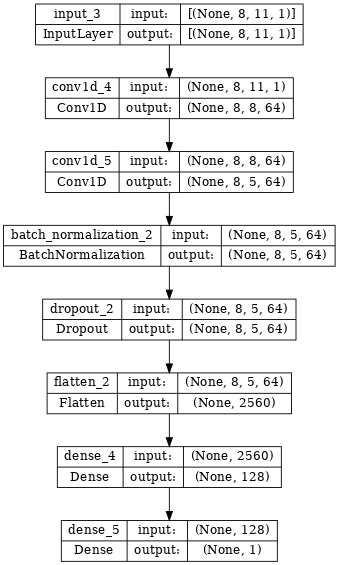

In [39]:
gen = predictor()
print(gen.count_params())
tf.keras.utils.plot_model(gen, show_shapes=True, dpi=64)

In [40]:
with strategy.scope():
    model = predictor()
    model_optimizer = tf.keras.optimizers.Adam()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "TEST_6")
checkpoint = tf.train.Checkpoint(model_optimizer=model_optimizer, model=model)
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + "TEST_6")

In [42]:
def sigmoid_loss(logits, labels):
    logits = tf.cast(logits, dtype=tf.float32)
    labels = tf.cast(labels, dtype=tf.float32)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(loss)
    return loss/N_GPU

def val_sigmoid_loss(inputs, labels):
    logits = model(inputs, training=True)
    logits = tf.cast(logits, dtype=tf.float32)
    labels = tf.cast(labels, dtype=tf.float32 )
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(loss)
    return loss/N_GPU

def train_model_step(inputs, target):
    with tf.GradientTape() as mod_tape:
        outputs = model(inputs, training=True)
        loss = sigmoid_loss(outputs, target)
        
    model_gradients=mod_tape.gradient(loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))
    return loss

@tf.function
def distributed_mod_train_step(inputs, target, step, val_input, val_target):
    loss = strategy.run(train_model_step, args=(inputs, target))
    val_loss = strategy.run(val_sigmoid_loss, args=(val_input, val_target))
    val_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, val_loss, axis=None)
    loss = strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None)
    with summary_writer.as_default():
        tf.summary.scalar('train_loss', loss, step=step)
        tf.summary.scalar('val_loss', val_loss, step=step)

In [43]:
def fit(train_ds, val_ds, steps):
    start = time.time()
    global step
    step = 0
    for train_data, val_data in zip(train_ds,val_ds):
        step += 1
        inputs, target = train_data
        val_input, val_target = val_data
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            print("Total Steps Needed: " + str(steps))
            print(f"Step: {step//1000}k")
        step1 = tf.convert_to_tensor(step, dtype=tf.int64)
        distributed_mod_train_step(inputs, target, step1, val_input, val_target)
        
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)
        if (step+1) % (5000) == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [44]:
tf.config.run_functions_eagerly(False)

In [ ]:
fit(train_dataset, val_dataset, steps=((BUFFER_SIZE//GLOBAL_BATCH_SIZE)*EPOCHS))

Time taken for 1000 steps: 24.43 sec

Total Steps Needed: 4350000
Step: 14k
.

In [12]:
test_dataset = tf.data.experimental.load("./TEST_DATA")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14508198898388417025


In [24]:
test_dataset = tf.data.experimental.load("./TEST_DATA").batch(64)

model = predictor()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "TEST_4")
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14508198898388417025


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14508198898388417025


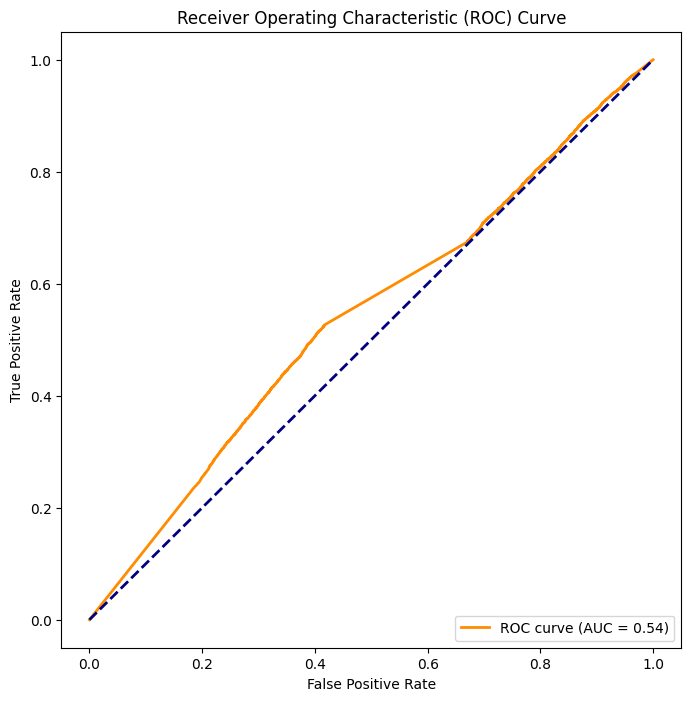

In [25]:
def get_predictions_and_labels(model, dataset):
    predictions = []
    true_labels = []

    for features, labels in dataset:
        predictions.append(model(features, training=False).numpy())
        true_labels.append(labels.numpy())

    predictions = tf.concat(predictions, axis=0)
    true_labels = tf.concat(true_labels, axis=0)

    return predictions, true_labels

predictions, true_labels = get_predictions_and_labels(model, test_dataset)

fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()